# Predicción de géneros musicales 

### Índice
1. Normalización y categorización
2. Construcción del modelo
3. Evaluación
4. Análisis de características

### 1. Normalización y categorización

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
music_df = pd.read_csv('unique_non_null_music_genre.csv')
print(music_df.head())
print(music_df.dtypes)

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out        27.0   
1      46652.0  Thievery Corporation      The Shining Path        31.0   
2      30097.0        Dillon Francis             Hurricane        28.0   
3      62177.0              Dubloadz                 Nitro        34.0   
4      24907.0           What So Not      Divide & Conquer        32.0   

   acousticness  danceability    duration_ms  energy  instrumentalness key  \
0       0.00468         0.652  212121.547485   0.941           0.79200  A#   
1       0.01270         0.622  218293.000000   0.890           0.95000   D   
2       0.00306         0.620  215613.000000   0.755           0.01180  G#   
3       0.02540         0.774  166875.000000   0.700           0.00253  C#   
4       0.00465         0.638  222369.000000   0.587           0.90900  F#   

   liveness  loudness   mode  speechiness    tempo  valence music_genre  
0     0.115 

In [51]:
# We have to normalize the data and categorize all non-numeric data
numeric_cols = music_df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = numeric_cols.drop('instance_id', errors='ignore')

categorical_cols = music_df.select_dtypes(include=['object']).columns
categorical_cols = categorical_cols.drop(['artist_name', 'track_name'], errors='ignore')

music_df[numeric_cols] = (music_df[numeric_cols] - music_df[numeric_cols].min()) / (music_df[numeric_cols].max() - music_df[numeric_cols].min())

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    music_df[col] = le.fit_transform(music_df[col])
    label_encoders[col] = le

print(music_df.head())

   instance_id           artist_name            track_name  popularity  \
0      32894.0              Röyksopp  Röyksopp's Night Out    0.272727   
1      46652.0  Thievery Corporation      The Shining Path    0.313131   
2      30097.0        Dillon Francis             Hurricane    0.282828   
3      62177.0              Dubloadz                 Nitro    0.343434   
4      24907.0           What So Not      Divide & Conquer    0.323232   

   acousticness  danceability  duration_ms    energy  instrumentalness  key  \
0      0.004699      0.639465     0.047828  0.941896          0.795181    1   
1      0.012751      0.607081     0.049100  0.890804          0.953815    5   
2      0.003072      0.604922     0.048547  0.755562          0.011847   11   
3      0.025502      0.771157     0.038499  0.700463          0.002540    4   
4      0.004669      0.624352     0.049940  0.587260          0.912651    9   

   liveness  loudness  mode  speechiness     tempo   valence  music_genre  
0  0

### 2. Construcción del modelo

In [52]:
# We have to split the data into features and target and use K-Fold cross validation
features = music_df.drop(columns=['instance_id', 'artist_name', 'track_name', 'music_genre'], errors='ignore')
target = music_df['music_genre']
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [53]:
# We train the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': MultinomialNB()
}  

class_names = label_encoders['music_genre'].classes_

### 3. Evaluación

Logistic Regression - Accuracy: 0.5097184178810124


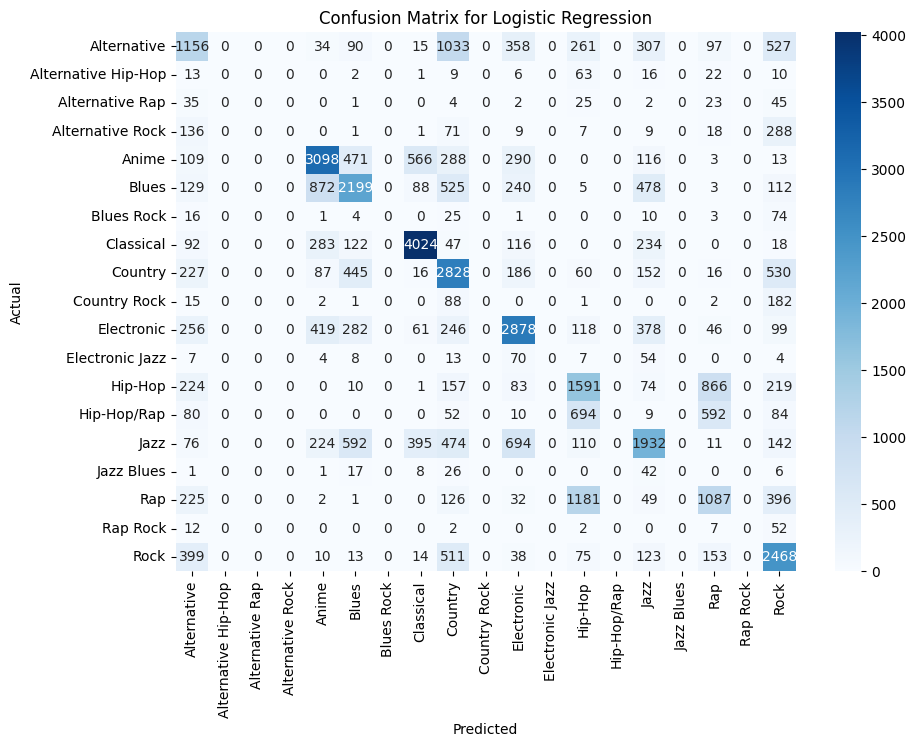

In [54]:
# Logistic Regression
model = models['Logistic Regression']
model_name = 'Logistic Regression'

predictions = cross_val_predict(model, features, target, cv=kf)
conf_matrix = confusion_matrix(target, predictions)
accuracy = accuracy_score(target, predictions)
print(f'{model_name} - Accuracy: {accuracy}')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for {model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()